# Feature Extraction
* A common method of EEG classification encountered during research of literary sources was feature extraction. 
* Using the data points of the signals is not a good way to classify.
* However, extracting statistical, and signal processing related features may help significantly improve our classification results.
* There are over a hundred features that can be extracted from EEG based on the sources read.
* This notebook will try to explore a few of in the following realms:
    1. Statisical 
        * mean, median, std, skewness, kurtosis, max and min
    2. Time Domain
        * hjorth paramter, 1st difference mean and maximum
    3. Frequency Domain
        * Converting time domain signals into frequency domain signals with Fourier transform.
        * Caluclating band power and max power with FT.
    4. Wavelet-based features
        * Discrete Wavelet Transform (High pass and Low Pass)
    5. Auto-regressive Coefficients
        * AR model of order 6 using Burg's Algorithm. Using the coefficients as features.
* All of the feature domains will be explained further throughout the notebook.

Source: [S. S. R, J. Rabha, K. Y. Nagarjuna, D. Samanta, P. Mitra and M. Sarma, "Motor Imagery EEG Signal Processing and Classification Using Machine Learning Approach," 2017 International Conference on New Trends in Computing Sciences (ICTCS), Amman, 2017, pp. 61-66.
doi: 10.1109/ICTCS.2017.15](https://ieeexplore-ieee-org.ccny-proxy1.libr.ccny.cuny.edu/document/8250265/citations)

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
import time
import pickle
#need this to create pipeline for classification
from sklearn.pipeline import make_pipeline
#for scaling data into n_sample * n_feature array
from sklearn.preprocessing import StandardScaler, MinMaxScaler, normalize
#classifer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
import mne
from mne.decoding import (SlidingEstimator, GeneralizingEstimator,
                         cross_val_multiscore, LinearModel, get_coef, Vectorizer,CSP)
from mne.preprocessing import Xdawn
import os
import os.path as op
from os import listdir
from os.path import isfile, join
matplotlib.rcParams['figure.figsize'] = (15.0, 10.0)
matplotlib.rcParams.update({'font.size': 15})

#data path for each run of each subject.
drive_data_path = 'E:\eeg_data'

#data path on my external hdd for folder containing all tests of each subject in one file
drive_all_data_path = 'E:\eeg_data\ica_140_500_0.1'

#local path
path = 'C:\Users\Esimk\OneDrive\Desktop\eeg_data'

In [10]:
%run Functions.ipynb

In [11]:
subject_runs = get_subject_runs(path)
filtered_epoch_files = get_filtered_epoch_files(subject_runs)


NameError: name 'get_subject_runs' is not defined

In [ ]:
# with open('filtered_epoch_files.pkl', 'w') as f:
#     pickle.dump(filtered_epoch_files, f)

In [3]:
with open('filtered_epoch_files.pkl', 'r') as f:
    files = np.array(pickle.load(f))

IOError: [Errno 2] No such file or directory: 'filtered_epoch_files.pkl'

In [4]:
filtered_epoch_files = []
for f in files:
    filtered_epoch_files.append(f)

# How much data do we have?

In [11]:
filtered_epochs_total = 0
for f in filtered_epoch_files:
    epochs = mne.read_epochs(f, preload = True)
    filtered_epochs_total += epochs.get_data().shape[0]

Reading C:\Users\Esimk\OneDrive\Desktop\eeg_data\Ex10_Suj10_Run1-epo.fif ...
Isotrak not found
    Read a total of 1 projection items:
        Average EEG reference (1 x 61) active
    Found the data of interest:
        t =       0.00 ...    1400.00 ms
        0 CTF compensation matrices available
294 matching events found
Created an SSP operator (subspace dimension = 1)
294 matching events found
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Reading C:\Users\Esimk\OneDrive\Desktop\eeg_data\Ex10_Suj10_Run2-epo.fif ...
Isotrak not found
    Read a total of 1 projection items:
        Average EEG reference (1 x 61) active
    Found the data of interest:
        t =       0.00 ...    1400.00 ms
        0 CTF compensation matrices available
286 matching events found
Created an SSP operator (subspace dimension = 1)
286 matching events found
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Reading C:\Users\Esimk\OneDrive\Desktop\ee

Isotrak not found
    Read a total of 1 projection items:
        Average EEG reference (1 x 61) active
    Found the data of interest:
        t =       0.00 ...    1400.00 ms
        0 CTF compensation matrices available
299 matching events found
Created an SSP operator (subspace dimension = 1)
299 matching events found
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Reading C:\Users\Esimk\OneDrive\Desktop\eeg_data\Ex10_Suj15_Run4-epo.fif ...
Isotrak not found
    Read a total of 1 projection items:
        Average EEG reference (1 x 61) active
    Found the data of interest:
        t =       0.00 ...    1400.00 ms
        0 CTF compensation matrices available
278 matching events found
Created an SSP operator (subspace dimension = 1)
278 matching events found
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Reading C:\Users\Esimk\OneDrive\Desktop\eeg_data\Ex10_Suj16_Run1-epo.fif ...
Isotrak not found
    Read a total of 1 pr

        Average EEG reference (1 x 61) active
    Found the data of interest:
        t =       0.00 ...    1400.00 ms
        0 CTF compensation matrices available
287 matching events found
Created an SSP operator (subspace dimension = 1)
287 matching events found
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Reading C:\Users\Esimk\OneDrive\Desktop\eeg_data\Ex10_Suj1_Run4-epo.fif ...
Isotrak not found
    Read a total of 1 projection items:
        Average EEG reference (1 x 61) active
    Found the data of interest:
        t =       0.00 ...    1400.00 ms
        0 CTF compensation matrices available
293 matching events found
Created an SSP operator (subspace dimension = 1)
293 matching events found
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Reading C:\Users\Esimk\OneDrive\Desktop\eeg_data\Ex10_Suj20_Run1-epo.fif ...
Isotrak not found
    Read a total of 1 projection items:
        Average EEG reference (1 x 61) acti

        t =       0.00 ...    1400.00 ms
        0 CTF compensation matrices available
263 matching events found
Created an SSP operator (subspace dimension = 1)
263 matching events found
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Reading C:\Users\Esimk\OneDrive\Desktop\eeg_data\Ex10_Suj27_Run1-epo.fif ...
Isotrak not found
    Read a total of 1 projection items:
        Average EEG reference (1 x 61) active
    Found the data of interest:
        t =       0.00 ...    1400.00 ms
        0 CTF compensation matrices available
302 matching events found
Created an SSP operator (subspace dimension = 1)
302 matching events found
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Reading C:\Users\Esimk\OneDrive\Desktop\eeg_data\Ex10_Suj27_Run2-epo.fif ...
Isotrak not found
    Read a total of 1 projection items:
        Average EEG reference (1 x 61) active
    Found the data of interest:
        t =       0.00 ...    1400.00 ms
 

281 matching events found
Created an SSP operator (subspace dimension = 1)
281 matching events found
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Reading C:\Users\Esimk\OneDrive\Desktop\eeg_data\Ex10_Suj5_Run3-epo.fif ...
Isotrak not found
    Read a total of 1 projection items:
        Average EEG reference (1 x 61) active
    Found the data of interest:
        t =       0.00 ...    1400.00 ms
        0 CTF compensation matrices available
256 matching events found
Created an SSP operator (subspace dimension = 1)
256 matching events found
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Reading C:\Users\Esimk\OneDrive\Desktop\eeg_data\Ex10_Suj5_Run4-epo.fif ...
Isotrak not found
    Read a total of 1 projection items:
        Average EEG reference (1 x 61) active
    Found the data of interest:
        t =       0.00 ...    1400.00 ms
        0 CTF compensation matrices available
221 matching events found
Created an SSP ope

In [15]:
print("total data with files with more than 200 epochs",filtered_epochs_total)

('total data with files with more than 200 epochs', 23389L)


In [6]:
#get a random epoch file greater than 200 epochs
np.random.seed(42)
epoch_f = filtered_epoch_files[np.random.choice(len(filtered_epoch_files))]
print("epoch file name", epoch_f)
epochs = mne.read_epochs(epoch_f, preload=True)

('epoch file name', 'C:\\Users\\Esimk\\OneDrive\\Desktop\\eeg_data\\Ex10_Suj24_Run4-epo.fif')
Reading C:\Users\Esimk\OneDrive\Desktop\eeg_data\Ex10_Suj24_Run4-epo.fif ...
Isotrak not found
    Read a total of 1 projection items:
        Average EEG reference (1 x 61) active
    Found the data of interest:
        t =       0.00 ...    1400.00 ms
        0 CTF compensation matrices available
263 matching events found
Created an SSP operator (subspace dimension = 1)
263 matching events found
Created an SSP operator (subspace dimension = 1)
1 projection items activated


In [6]:
# select channels near the visual cortex
# epochs.pick_channels(['O1','O2','P7','P8'])

<EpochsFIF  |  n_events : 263 (all good), tmin : 0.0 (s), tmax : 1.4 (s), baseline : (0.0, 0.0), ~11.3 MB, data loaded,
 u'after': 66, u'before': 70, u'new': 67, u'scramble': 60>

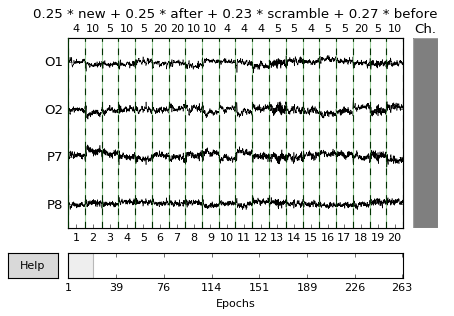

In [7]:
epochs.plot();

## Statistical Domain

In [8]:
def stat_of_epochs(epochs, stat):
    epoch_stats = np.empty(len(epochs))
    count = 0
    for i in range(len(epochs)):
        stats = np.empty(len(epochs.ch_names))
        for j in range(len(epochs.ch_names)):
            stats[j] = stat(epochs.get_data()[i,j,:])
            count +=1
        epoch_stats[i] = np.mean(stats)
    return epoch_stats

### Mean

In [96]:
mean = stat_of_epochs(epochs, np.mean)

### Standard Deviation

In [97]:
std = stat_of_epochs(epochs, np.std)

### Median

In [98]:
median = stat_of_epochs(epochs, np.median)

### Kurtosis

In [99]:
kurt = stat_of_epochs(epochs, stats.kurtosis)

### Skewness

In [100]:
skew = stat_of_epochs(epochs, stats.skew)

## Classification with these statistics

In [101]:
d = {'mean':mean, 'median':median,
     'std':std,'kurtosis': kurt, 
     'skewness':skew}
df = pd.DataFrame(data =d)
df['event'] = epochs.events[:,-1]
df.head()

,kurtosis,mean,median,skewness,std,event
0,0.998987,4.165736e-23,2.208593e-08,-0.135457,0.000007,4
1,0.252257,8.331472e-23,-1.700028e-08,0.012385,0.000008,10
2,0.428491,-2.221726e-22,-2.625405e-08,-0.108804,0.000008,5
3,0.095261,-1.770438e-22,4.162866e-08,-0.092538,0.000007,10
4,0.076405,-3.888020e-22,-1.831880e-07,0.018211,0.000008,5


In [102]:
df_scram_new = df[(df.event == 5) | (df.event == 4)]
df_scram_new = df_scram_new.reset_index(drop=True)

In [103]:
val2 = df_scram_new['kurtosis'][df_scram_new['event'] == 4]
val2 = val2.values.reshape(-1,1)
sc = StandardScaler()
val2 = sc.fit_transform(val2)
# val2 = normalize(val2)
# val2

In [104]:
val1 = df_scram_new['skewness'][df_scram_new['event'] == 4]
val1 = val1.values.reshape(-1,1)
sc1 = StandardScaler()
val1 = sc1.fit_transform(val1)
# val1 = normalize(val1)

In [105]:
val3 = df_scram_new['kurtosis'][df_scram_new['event'] == 5]
val3 = val3.values.reshape(-1,1)
sc2 = StandardScaler()
val3 = sc2.fit_transform(val3)

In [106]:
val4 = df_scram_new['skewness'][df_scram_new['event'] == 5]
val4 = val4.values.reshape(-1,1)
sc3 = StandardScaler()
val4 = sc3.fit_transform(val4)

### Plotting Features

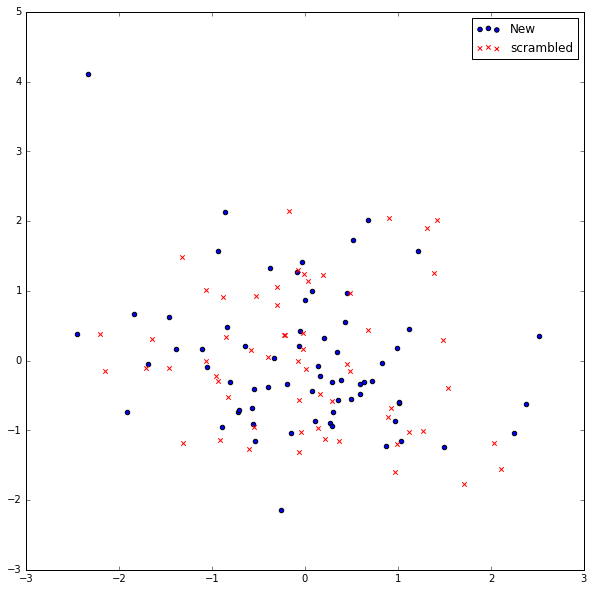

In [108]:
fig, ax = plt.subplots(figsize = (10,10))
# val1 = df_scram_new['mean'][df_scram_new['event'] == 4]
# val2 = df_scram_new['median'][df_scram_new['event'] == 4]
ax.scatter(val1, val2, c= 'b', label = 'New')
ax.scatter(val3, val4, c= 'r', label = 'scrambled', marker = 'x')

# ax.scatter(df_scram_new['mean'][df_scram_new['event'] == 5], 
#            df_scram_new['std'][df_scram_new['event'] == 5], c= 'r', label = 'Scrambled')
ax.legend();

In [38]:
X = df_scram_new.iloc[:,:-1].values
y = df_scram_new.iloc[:,-1:].values

In [263]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = .30, random_state = 42)
clf = make_pipeline(StandardScaler(), LogisticRegression())


In [264]:
clf.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('logisticregression', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [265]:
clf.score(X_test, y_test)

0.53846153846153844

In [266]:
X.shape

(127L, 5L)

In [12]:
path = 'E:\eeg_data'
epochs = mne.read_epochs(os.path.join(path, 'Ex10_Suj13_Run1-epo.fif'), preload=True)

Reading E:\eeg_data\Ex10_Suj13_Run1-epo.fif ...
Isotrak not found
    Read a total of 1 projection items:
        Average EEG reference (1 x 61) active
    Found the data of interest:
        t =       0.00 ...    1400.00 ms
        0 CTF compensation matrices available
304 matching events found
Created an SSP operator (subspace dimension = 1)
304 matching events found
Created an SSP operator (subspace dimension = 1)
1 projection items activated


In [7]:
epochs.event_id

{u'after': 20, u'before': 10, u'new': 4, u'scramble': 5}

In [14]:
epochs.events

array([[   6026,       0,       4],
       [  15852,       0,      10],
       [  22560,       0,       5],
       [  24762,       0,      20],
       [  28599,       0,      10],
       [  31990,       0,       5],
       [  37411,       0,       5],
       [  42080,       0,       4],
       [  45348,       0,      10],
       [  47287,       0,       4],
       [  49951,       0,      10],
       [  53409,       0,      20],
       [  55290,       0,      20],
       [  57748,       0,       4],
       [  61766,       0,       5],
       [  64431,       0,      10],
       [  66073,       0,      10],
       [  67707,       0,      10],
       [  70677,       0,       5],
       [  74159,       0,       5],
       [  76617,       0,      20],
       [  79753,       0,      10],
       [  82170,       0,       4],
       [  84134,       0,      10],
       [  86007,       0,      20],
       [  87822,       0,       4],
       [  89579,       0,      10],
       [  92062,       0,   

In [17]:
epochs = mne.read_epochs(os.path.join(path, 'Ex10_Suj23_Run3-epo.fif'), preload=True)

Reading E:\eeg_data\Ex10_Suj23_Run3-epo.fif ...
Isotrak not found
    Read a total of 1 projection items:
        Average EEG reference (1 x 61) active
    Found the data of interest:
        t =       0.00 ...    1400.00 ms
        0 CTF compensation matrices available
305 matching events found
Created an SSP operator (subspace dimension = 1)
305 matching events found
Created an SSP operator (subspace dimension = 1)
1 projection items activated


In [18]:
epochs.events

array([[  21565,       0,       5],
       [  23715,       0,       4],
       [  26615,       0,       4],
       [  32848,       0,       4],
       [  38815,       0,      10],
       [  42965,       0,      10],
       [  51715,       0,       4],
       [  59299,       0,       4],
       [  62749,       0,       5],
       [  65149,       0,      10],
       [  67416,       0,       4],
       [  69366,       0,      10],
       [  71666,       0,      10],
       [  73699,       0,       5],
       [  76933,       0,      10],
       [  86616,       0,      20],
       [  94783,       0,      10],
       [ 101017,       0,       5],
       [ 102867,       0,       4],
       [ 105400,       0,       5],
       [ 107700,       0,      10],
       [ 111033,       0,       5],
       [ 115017,       0,      10],
       [ 117850,       0,      20],
       [ 120234,       0,       4],
       [ 123367,       0,       5],
       [ 126384,       0,       5],
       [ 128284,       0,   

In [41]:
# Ex10_Suj16_Run3-epo.fif
epochs2 = mne.read_epochs(os.path.join(path, 'Ex10_Suj16_Run3-epo.fif'), preload=True)

Reading E:\eeg_data\Ex10_Suj16_Run3-epo.fif ...
Isotrak not found
    Read a total of 1 projection items:
        Average EEG reference (1 x 61) active
    Found the data of interest:
        t =       0.00 ...    1400.00 ms
        0 CTF compensation matrices available
305 matching events found
Created an SSP operator (subspace dimension = 1)
305 matching events found
Created an SSP operator (subspace dimension = 1)
1 projection items activated


In [43]:
epochs2.events

array([[  24370,       0,       5],
       [  26520,       0,       4],
       [  29437,       0,       4],
       [  35654,       0,       4],
       [  41621,       0,      10],
       [  45771,       0,      10],
       [  54521,       0,       4],
       [  62104,       0,       4],
       [  65555,       0,       5],
       [  67955,       0,      10],
       [  70205,       0,       4],
       [  72155,       0,      10],
       [  74471,       0,      10],
       [  76505,       0,       5],
       [  79738,       0,      10],
       [  89422,       0,      20],
       [  97589,       0,      10],
       [ 103822,       0,       5],
       [ 105672,       0,       4],
       [ 108205,       0,       5],
       [ 110506,       0,      10],
       [ 113839,       0,       5],
       [ 117822,       0,      10],
       [ 120656,       0,      20],
       [ 123039,       0,       4],
       [ 126173,       0,       5],
       [ 129189,       0,       5],
       [ 131089,       0,   

In [48]:
print(np.max(abs(epochs.events[:,0] - epochs2.events[:,0])))
np.min(abs(epochs.events[:,0] - epochs2.events[:,0]))

2823


2788

In [32]:
epochs_run1_1 = mne.read_epochs(os.path.join(path, 'Ex10_Suj13_Run1-epo.fif'), preload=True)

Reading E:\eeg_data\Ex10_Suj13_Run1-epo.fif ...
Isotrak not found
    Read a total of 1 projection items:
        Average EEG reference (1 x 61) active
    Found the data of interest:
        t =       0.00 ...    1400.00 ms
        0 CTF compensation matrices available
304 matching events found
Created an SSP operator (subspace dimension = 1)
304 matching events found
Created an SSP operator (subspace dimension = 1)
1 projection items activated


In [33]:
# Ex10_Suj20_Run1-epo.fif
epochs_run1_2 = mne.read_epochs(os.path.join(path, 'Ex10_Suj20_Run1-epo.fif'), preload=True)

Reading E:\eeg_data\Ex10_Suj20_Run1-epo.fif ...
Isotrak not found
    Read a total of 1 projection items:
        Average EEG reference (1 x 61) active
    Found the data of interest:
        t =       0.00 ...    1400.00 ms
        0 CTF compensation matrices available
302 matching events found
Created an SSP operator (subspace dimension = 1)
302 matching events found
Created an SSP operator (subspace dimension = 1)
1 projection items activated


In [38]:
for time_stamp in epochs_run1_2.events[:,0]:
    
    if time_stamp in epochs_run1_1.events[:,0]:
        print(time_stamp)

5885
15702
22468
24685
28435
31885
37302
41902
45169
47169
49802
53319
55219
57586
61669
64236
65903
67553
70586
74069
76520
79586
82003
84020
85920
87536
89420
91970
94037
96253
99653
106604
110420
113354
116404
118554
121554
127354
133221
135121
137704
142321
145488
148271
150721
154155
157221
165355
167855
170605
172288
174205
176088
177722
182855
185672
188539
193056
196356
202489
206506
208706
216189
222306
227656
231556
237507
240607
242807
245907
247957
252490
255624
257840
259507
262157
263790
265874
268024
271157
273257
275041
276607
278108
279808
281374
282974
284641
286908
291858
294825
298641
302541
305475
307358
311475
316225
321892
327609
332942
340759
346759
348642
350593
352459
356826
362809
366126
371360
375526
378643
381626
383610
388243
394277
396610
398810
401227
406094
410994
413677
415811
417944
420627
422611
424394
426161
427811
429311
431628
435711
437478
439311
442561
444728
446845
450395
452945
455928
462495
470612
479362
484746
490079
492446
495646
499996
502

IndexError: arrays used as indices must be of integer (or boolean) type

In [39]:
epochs_run1_1.events

array([[   6026,       0,       4],
       [  15852,       0,      10],
       [  22560,       0,       5],
       [  24762,       0,      20],
       [  28599,       0,      10],
       [  31990,       0,       5],
       [  37411,       0,       5],
       [  42080,       0,       4],
       [  45348,       0,      10],
       [  47287,       0,       4],
       [  49951,       0,      10],
       [  53409,       0,      20],
       [  55290,       0,      20],
       [  57748,       0,       4],
       [  61766,       0,       5],
       [  64431,       0,      10],
       [  66073,       0,      10],
       [  67707,       0,      10],
       [  70677,       0,       5],
       [  74159,       0,       5],
       [  76617,       0,      20],
       [  79753,       0,      10],
       [  82170,       0,       4],
       [  84134,       0,      10],
       [  86007,       0,      20],
       [  87822,       0,       4],
       [  89579,       0,      10],
       [  92062,       0,   

In [40]:
epochs_run1_2.events

array([[   5885,       0,       4],
       [  15702,       0,      10],
       [  22468,       0,       5],
       [  24685,       0,      20],
       [  28435,       0,      10],
       [  31885,       0,       5],
       [  37302,       0,       5],
       [  41902,       0,       4],
       [  45169,       0,      10],
       [  47169,       0,       4],
       [  49802,       0,      10],
       [  53319,       0,      20],
       [  55219,       0,      20],
       [  57586,       0,       4],
       [  61669,       0,       5],
       [  64236,       0,      10],
       [  65903,       0,      10],
       [  67553,       0,      10],
       [  70586,       0,       5],
       [  74069,       0,       5],
       [  76520,       0,      20],
       [  79586,       0,      10],
       [  82003,       0,       4],
       [  84020,       0,      10],
       [  85920,       0,      20],
       [  87536,       0,       4],
       [  89420,       0,      10],
       [  91970,       0,   